In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
from autoviml.Auto_ViML import Auto_ViML
from langdetect import detect, DetectorFactory
    
DetectorFactory.seed = 0

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Moi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\


Imported Auto_NLP version: 0.0.44.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)
Imported Auto_ViML version: 0.1.663. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            
To remove previous versions, perform 'pip uninstall autoviml'
NEW! Now Auto_ViML comes with a feature_engineering module using featuretools library!
To get the latest versio

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')
sub.columns.unique()

Index(['Acoustic/Folk_0', 'Alt_Music_1', 'Blues_2', 'Bollywood_3', 'Country_4',
       'HipHop_5', 'Indie Alt_6', 'Instrumental_7', 'Metal_8', 'Pop_9',
       'Rock_10'],
      dtype='object')

In [3]:
test['Class'] = -1
# Coalescing the two columns for data treatment
full=train.append(test)
full=full.reset_index()
full=full.drop('index',axis=1)
print(full.shape)

(25709, 17)


In [4]:
# Preprocessing and feature extraction
dur = full['duration_in min/ms']
track = []
clean = []
for i in dur:
    if i<=100 :
        clean.append(i)
        track.append(0)
    else:
        clean.append(i/60000)
        track.append(1)
full['duration_in min/ms'] = clean
full['new1'] = track

In [5]:
# Feature engineering 

def count_special_character(string):  
    special_char= 0
    for i in range(0, len(string)):       
        ch = string[i]
        if (string[i].isdigit()):
            continue      
        else: 
            special_char += 1
    return special_char

def feature_engineering(df):
    #New features
    print("Adding new features")
    df['new2'] = df['Artist Name'].apply(len)                  #lenght of Artist Name
    df['new3'] = df['Track Name'].apply(len)             #Lenht of Song_Name
    df['new4'] = df['Artist Name'].str.split().str.len()          #Words in Artist Name
    df['new5'] = df['Track Name'].str.split().str.len()     #Words in Song_Name
    df['new6'] = df['Artist Name'].str.findall(r'[A-Z]').str.len() #Count Uppercases in name
    df['new7'] = df['Artist Name'].str.findall(r'[a-z]').str.len() #Count Lowercases in name
    df['new8'] = df['Artist Name'].str.findall(r'[0-9]').str.len() #Count Digits in name
    df['new9'] = df['Track Name'].str.findall(r'[A-Z]').str.len() #Count Uppercases in Song_Name
    df['new10'] = df['Track Name'].str.findall(r'[a-z]').str.len() #Count Lowercases in Song_Name
    df['new11'] = df['Track Name'].str.findall(r'[0-9]').str.len() #Count Digits in Song_Name
    df['new12'] = df['new2'] - (df['new6'] + df['new7']) #Count others char Artist Name
    df['new12'] = df['new3'] - (df['new9'] + df['new10']) #Count others char in Song_Name

feature_engineering(full)

Adding new features


In [6]:
# Clean up text using regex
import re
def clean_text(text):
    text = text.lower()
    #text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    #text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    #text = re.sub(r'www.[^ ]+', '', text)  
    #text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    #text = re.sub(r'[^a-zA-Z]', ' ', text)   
    #text = [token for token in text.split() if len(token) > 2]
    #text = ' '.join(text)
    return text

full['Artist Name'] = full['Artist Name'].apply(clean_text)
full['Track Name'] = full['Track Name'].apply(clean_text)

In [7]:
# additional feature  
full['truc'] = full['Artist Name'] + full['Track Name'] + full['Artist Name'] + full['Track Name'] + full['Artist Name'] + full['Track Name']
txt = full['truc']
lang = []
for i in tqdm(txt):
    try:
        lang.append(detect(i))
    except:
        lang.append('err')
         
del full['truc']
full['lang'] = lang



100%|████████████████████████████████████████████████████████████████████████████| 25709/25709 [06:44<00:00, 63.52it/s]


In [8]:
train2 = full[full['Class']!=-1]
test2 = full[full['Class']==-1]

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (17996, 30)
    Training Set Memory Usage = 4.26 MB
Test Set Shape = (7713, 30)
    Test Set Memory Usage = 1.82 MB
Single_Label Target: ['Class']
ALERT! Setting Imbalanced_Flag to True in Auto_ViML for Multi_Classification problems improves results!
Shuffling the data set before training
       Class  -> Counts -> Percent
           0:     625  ->    3.5%
           1:    1373  ->    7.6%
           2:    1272  ->    7.1%
           3:     402  ->    2.2%
           4:     387  ->    2.2%
           5:    1447  ->    8.0%
           6:    2587  ->   14.4%
           7:     576  ->    3.2%
           8:    1854  ->   10.3%
           9:    2524  ->   14.0%
          10:    4949  ->   27.5%
Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
CAUTION: In Multi-Class Boosting (2+ classes), TRAINING WILL TAKE A LOT OF TIME!
    Target Class is already numer

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067159


0:	test: 0.8936303	best: 0.8936303 (0)	total: 285ms	remaining: 18m 57s
100:	test: 0.9786202	best: 0.9786202 (100)	total: 14.4s	remaining: 9m 14s
200:	test: 0.9813256	best: 0.9813256 (200)	total: 29.1s	remaining: 9m 9s
300:	test: 0.9819605	best: 0.9819605 (300)	total: 43.1s	remaining: 8m 49s
400:	test: 0.9821407	best: 0.9821635 (395)	total: 57.1s	remaining: 8m 32s
500:	test: 0.9820786	best: 0.9821635 (395)	total: 1m 10s	remaining: 8m 9s
600:	test: 0.9820905	best: 0.9822036 (565)	total: 1m 24s	remaining: 7m 56s
700:	test: 0.9829429	best: 0.9829429 (700)	total: 1m 37s	remaining: 7m 40s
800:	test: 0.9831500	best: 0.9831522 (799)	total: 1m 53s	remaining: 7m 31s
900:	test: 0.9832098	best: 0.9832345 (896)	total: 2m 7s	remaining: 7m 20s
1000:	test: 0.9831991	best: 0.9833022 (939)	total: 2m 23s	remaining: 7m 10s
1100:	test: 0.9833244	best: 0.9833522 (1041)	total: 2m 41s	remaining: 7m 5s
1200:	test: 0.9832724	best: 0.9833522 (1041)	total: 2m 59s	remaining: 6m 58s
Stopped by overfitting detector 

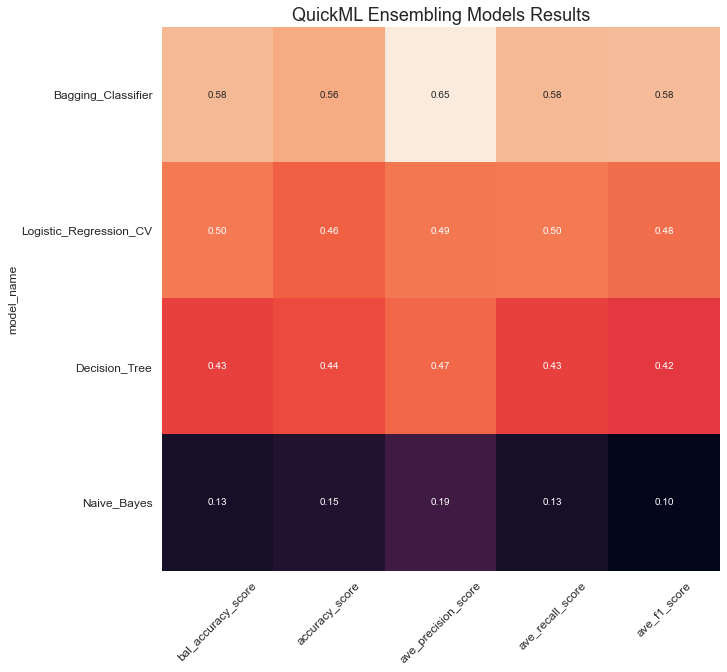

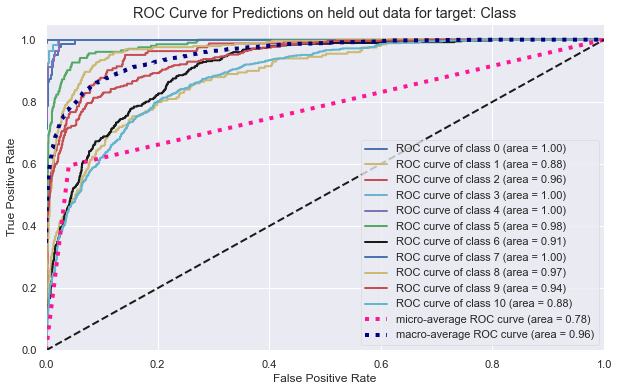

Average precision score, micro-averaged over all classes: 0.78
Macro F1 score, averaged over all classes: 0.74


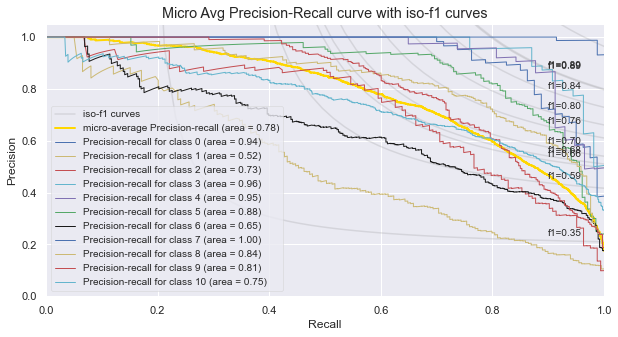

After multiple models, Ensemble Model Results:
    Balanced Accuracy Score = 73.226%
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        80
           1       0.75      0.23      0.35       199
           2       0.62      0.71      0.66       163
           3       0.90      0.87      0.89        54
           4       0.94      0.84      0.89        57
           5       0.82      0.77      0.80       204
           6       0.60      0.57      0.59       376
           7       0.98      0.99      0.98        82
           8       0.78      0.74      0.76       290
           9       0.70      0.70      0.70       353
          10       0.61      0.75      0.68       713

    accuracy                           0.69      2571
   macro avg       0.77      0.73      0.74      2571
weighted avg       0.70      0.69      0.68      2571

[[ 70   0   0   4   0   0   0   1   0   2   3]
 [  0  45  12   0   0   6  53   0   4   8  71]
 [  0   

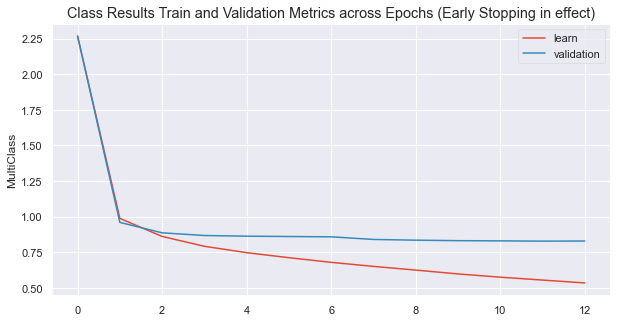

    Time taken for this Target (in seconds) = 338
Training model on complete Train data and Predicting using give Test Data...
    Binning_Flag set to False or there are no numeric vars in data set to be binned
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 20
For CatBoost, feature scaling is not required. Continuing...
0:	total: 217ms	remaining: 3m 45s
100:	total: 24s	remaining: 3m 43s
200:	total: 46.5s	remaining: 3m 14s
300:	total: 1m 7s	remaining: 2m 46s
400:	total: 1m 28s	remaining: 2m 21s
500:	total: 1m 48s	remaining: 1m 57s
600:	total: 2m 10s	remaining: 1m 35s
700:	total: 2m 29s	remaining: 1m 12s
800:	total: 2m 50s	remaining: 51.1s
900:	total: 3m 12s	remaining: 29.9s
1000:	total: 3m 32s	remaining: 8.5s
1040:	total: 3m 40s	remaining: 0us
Actual Training time taken in seconds = 221
    Calculating weighted average ensemble of 5 classi

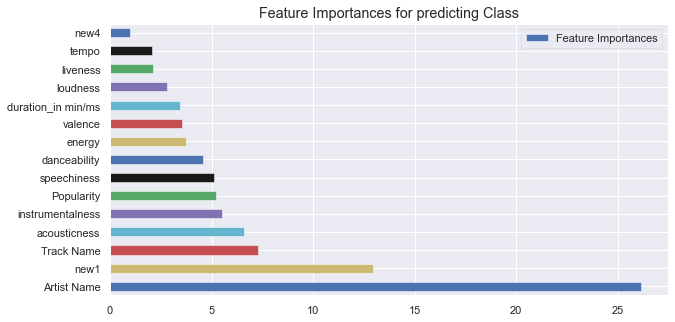

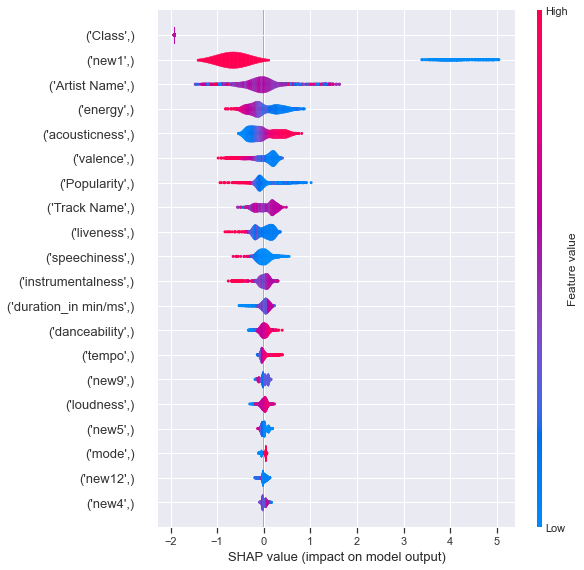

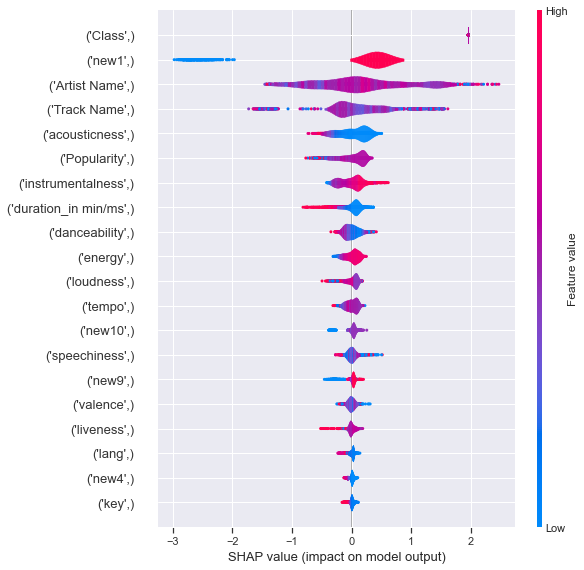

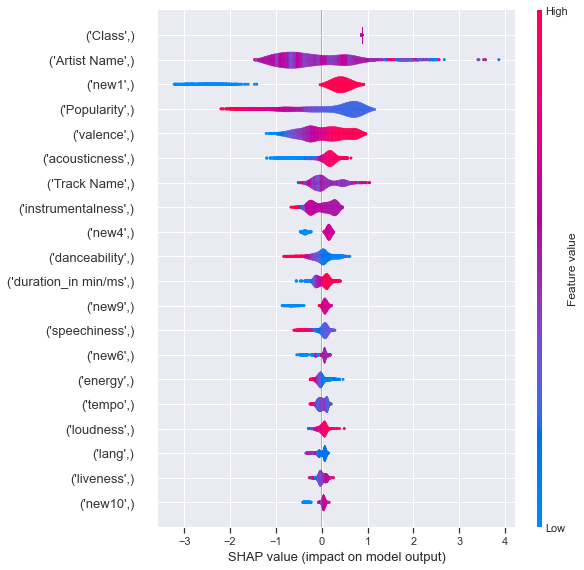

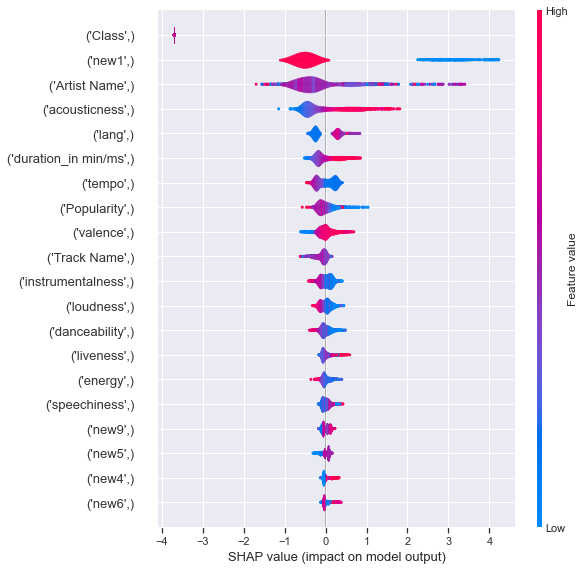

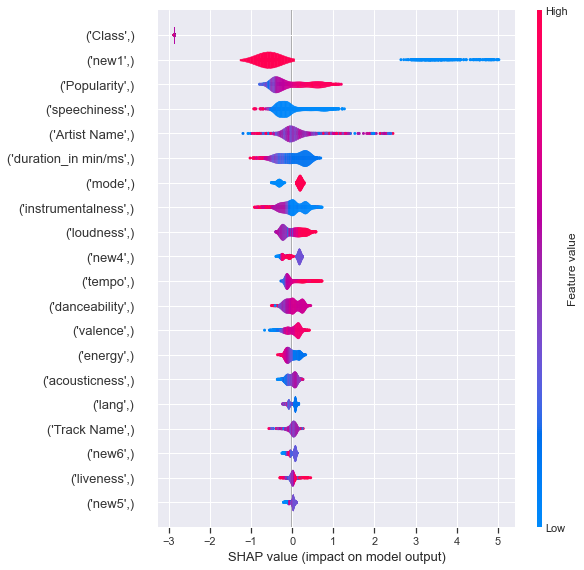

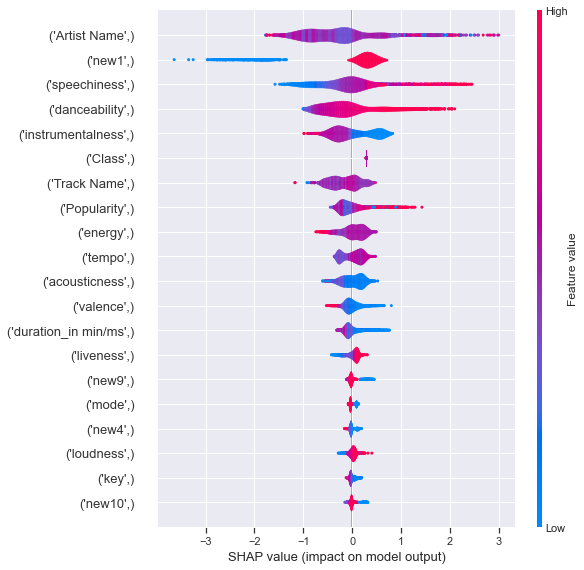

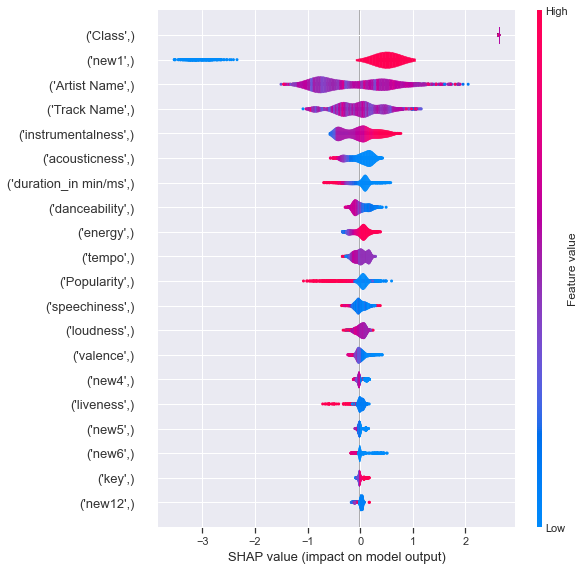

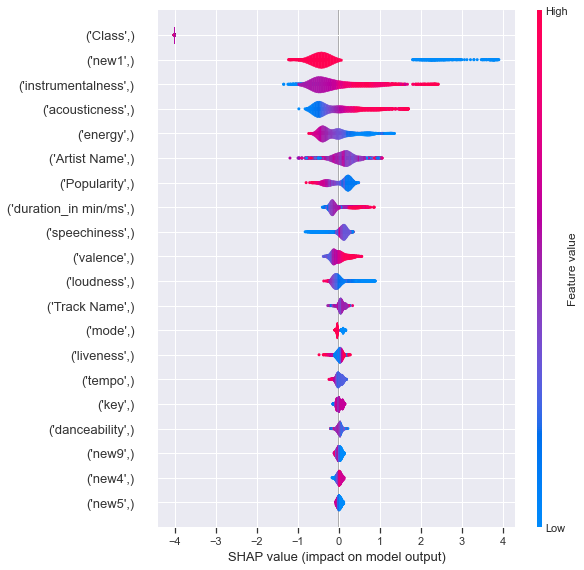

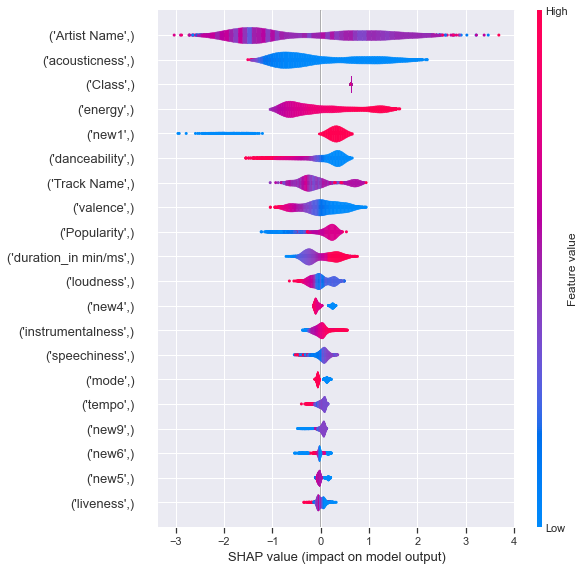

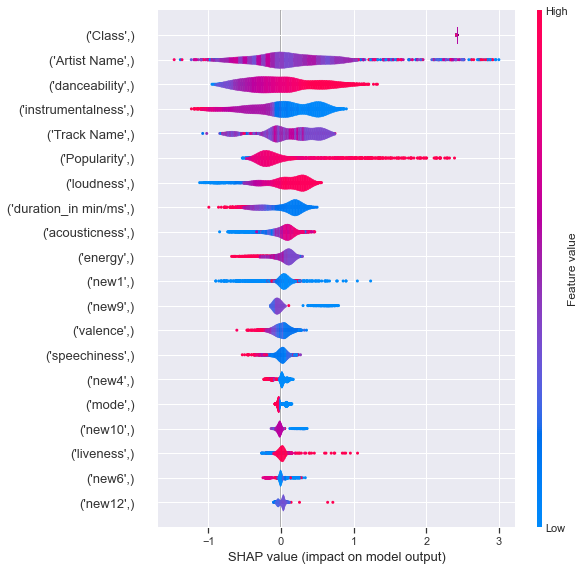

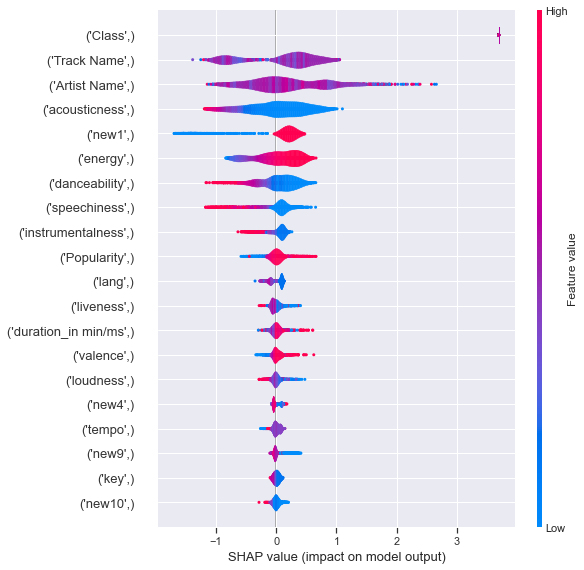

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken for this Target (in seconds) = 747
Writing Output files to disk...
    Saving predictions to .\Class\Class_Multi_Classification_test_modified.csv
    Saving predictions to .\Class\Class_Multi_Classification_submission.csv
    Saving predictions to .\Class\Class_Multi_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 12.5 for the Entire Process


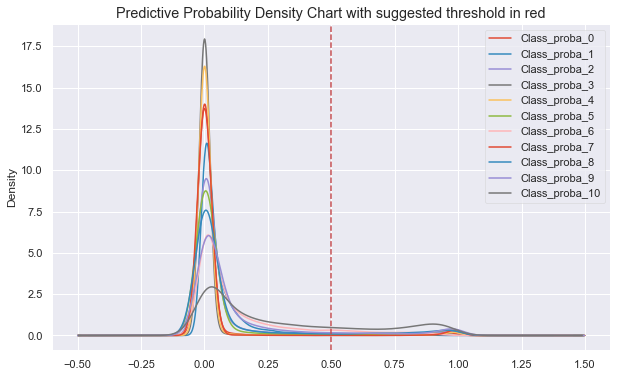

In [9]:
target  = 'Class'
model, features, trainm, testm = Auto_ViML(
    train2,
    target,
    test2,
    #sub,
    hyper_param="RS",
    feature_reduction=False,
    scoring_parameter= "accuracy",#"neg_log_loss",#
    KMeans_Featurizer=False,
    Boosting_Flag= 'catboost',#True,#
    Binning_Flag=False,
    Add_Poly=0,
    Stacking_Flag=False,
    Imbalanced_Flag=False,
    verbose=2
)

In [10]:
testm.to_csv('testm.csv',index=False)
testm = pd.read_csv('testm.csv')

In [11]:
# submition file build
sub['Acoustic/Folk_0']= testm['Class_proba_0']
sub['Alt_Music_1']= testm['Class_proba_1']
sub['Blues_2']= testm['Class_proba_2']
sub['Bollywood_3']= testm['Class_proba_3']
sub['Country_4']= testm['Class_proba_4']
sub['HipHop_5']= testm['Class_proba_5']
sub['Indie Alt_6']= testm['Class_proba_6']
sub['Instrumental_7']= testm['Class_proba_7']
sub['Metal_8']= testm['Class_proba_8']
sub['Pop_9']= testm['Class_proba_9']
sub['Rock_10']= testm['Class_proba_10']

In [12]:
sub.to_csv('baseline_v4c.csv',index=False)# cv:0.9832724 lb:0.70174 - reproduce ok